In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("data.csv")
df.head()

,person ID,age,gender,chest pain type,resting blood pressure,serum cholesterol in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak = ST depression induced by exercise relative to rest,the slope of the peak exercise ST segment,number of major vessels (0-3) colored by flourosopy,Has heart disease? (Prediction Target)
0,1,63,M,Type 3,145,233,Yes,hypertrophy of heart,150,No,2.3,0,0,Yes
1,2,37,M,Type 2,130,250,No,myocardial infarction,187,No,3.5,0,0,Yes
2,3,41,F,Type 1,130,204,No,hypertrophy of heart,172,No,1.4,2,0,Yes
3,4,56,M,Type 1,120,236,No,myocardial infarction,178,No,0.8,2,0,Yes
4,5,57,F,Type 0,120,354,No,myocardial infarction,163,Yes,0.6,2,0,Yes


In [3]:
# print(df.describe())
print(df.isna().sum())

person ID                                                       0
age                                                             0
gender                                                          0
chest pain type                                                 0
resting blood pressure                                          0
serum cholesterol in mg/dl                                      0
fasting blood sugar > 120 mg/dl                                 0
resting electrocardiographic results                            0
maximum heart rate achieved                                     0
exercise induced angina                                         0
oldpeak = ST depression induced by exercise relative to rest    0
the slope of the peak exercise ST segment                       0
number of major vessels (0-3) colored by flourosopy             0
Has heart disease? (Prediction Target)                          0
dtype: int64


# Preprocessing

In [4]:
label_mappings = {}
categorical_cols = [
    "gender",
    "chest pain type", 
    "fasting blood sugar > 120 mg/dl", 
    "resting electrocardiographic results",
    "exercise induced angina",
    "Has heart disease? (Prediction Target)"
]
encoded_df = df.copy()

for col in categorical_cols:
    encoder = LabelEncoder()
    encoded_df[col] = encoder.fit_transform(encoded_df[col])
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [5]:
for k, v in label_mappings.items():
    print(k)

    for k2, v2 in v.items():
        print(f"{k2}:\t{v2}")
    print("---"*10)

gender
F:	0
M:	1
------------------------------
chest pain type
Type 0:	0
Type 1:	1
Type 2:	2
Type 3:	3
------------------------------
fasting blood sugar > 120 mg/dl
No:	0
Yes:	1
------------------------------
resting electrocardiographic results
hypertrophy of heart:	0
ischemia:	1
myocardial infarction:	2
------------------------------
exercise induced angina
No:	0
Yes:	1
------------------------------
Has heart disease? (Prediction Target)
No:	0
Yes:	1
------------------------------


# Development

In [18]:
def generate_splitpoints(df: pd.DataFrame, col: str) -> np.ndarray:
    """
    Generate split points for a numeric column in a pandas DataFrame.
    Computes possible split points by taking midpoints between every consecutive unique point.

    Parameters:
    ---
        df: pd.DataFrame
            Input DataFrame
    
        col: str
            Name of the column to generate splitpoints for

    Returns:
    ---
        ret: np.ndarray
            An array of n-1 floats storing the splitpoints, where n is the number of unique values in the column
    """
    assert df is not None, "Dataframe does not exist"
    assert col in list(df.columns), "The column is not in the dataframe"
    assert pd.api.types.is_numeric_dtype(df[col]), "The column is not numeric"

    vals = df[col].unique()
    vals.sort()
    n = len(vals)

    ret = np.zeros(n - 1)
    
    for i in range(n - 1):
        ret[i] = 1/2 * (vals[i] + vals[i+1])

    return ret

In [19]:
# def entropy(left: tuple, right: tuple, N: int):
#     """
#     Compute the information entropy for a left and right split

#     Parameters:
#     ---
#         left: tuple
#             A tuple representing the counts of classes in the left node. For this homework, (T, F) is used
#         right: tuple
#             A tuple representing the counts of classes in the right node. For this homework, (T, F) is used
#         N: int
#             The total number of entries

#     Returns:
#     ---
#         ent: float
#             The calculated information entropy, or infinity if there is an empty split
#     """
#     n_left = sum(left)
#     n_right = sum(right)

#     # Empty nodes
#     if n_left == 0 or n_right == 0:
#         return float('inf')

#     # Left split entropy
#     left_weight = n_left/N

#     p_left_true = left[0]/n_left
#     p_left_false = left[1]/n_left
    
#     ent_left = 0
#     if p_left_true > 0: ent_left -= p_left_true * np.log2(p_left_true)
#     if p_left_false > 0: ent_left -= p_left_false * np.log2(p_left_false)

#     # Right split entropy
#     right_weight = n_right/N

#     p_right_true = right[0]/n_right
#     p_right_false = right[1]/n_right

#     ent_right = 0
#     if p_right_true > 0: ent_right -= p_right_true * np.log2(p_right_true)
#     if p_right_false > 0: ent_right -= p_right_false * np.log2(p_right_false)

#     # Weighted entropy
#     ent = left_weight * ent_left + right_weight * ent_right
#     return ent

In [20]:
def entropy(counts: tuple) -> float:
    """
    Calculate entropy for a node with given class counts

    Parameters:
    ---
        counts: tuple
            A tuple representing the counts of classes in the node. For this homework (#T, #F) is used
    """
    
    total = sum(counts)
    if total == 0:
        return 0
    
    entropy_val = 0
    for count in counts:
        prob = count / total
        if prob > 0:  # Avoid log(0)
            entropy_val -= prob * np.log2(prob)
    
    return entropy_val

In [21]:
def information_gain(left: tuple, right: tuple, parent: tuple) -> float:
    """
    Calculate information gain from a split
    
    Parameters:
    ---
        left: tuple
            A tuple of class counts in left child (#T, #F)
        right: tuple
            A tuple of class counts in right child (#T, #F)
        parent: tuple
            A tuple of class counts in parent node (#T, #F)  
            
    Returns:
    ---
        IG: float
            Information gain from the split
    """
    n_parent = sum(parent)
    n_left = sum(left)
    n_right = sum(right)
    
    if n_parent == 0:
        return 0
    
    # Parent entropy
    parent_entropy = entropy(parent)
    
    # Weighted average of children entropy
    left_weight = n_left / n_parent
    right_weight = n_right / n_parent
    
    children_entropy = left_weight * entropy(left) + right_weight * entropy(right)

    IG = parent_entropy - children_entropy
    return IG

In [36]:
def find_split(df: pd.DataFrame, split_col: str, label_col: str, metric: str = "IG"):
    # Cannot split
    if df.empty or df[split_col].nunique() <= 1:
        return None, 0.0
    
    splitpoints = generate_splitpoints(df, split_col)
    if len(splitpoints) == 0:
        return None, 0.0
    
    # Get subset for calculation
    data = df[[split_col, label_col]].to_numpy()
    data = data[data[:, 0].argsort()]

    parent_counts = (
        len(data[data[:, 1] == 1]),
        len(data[data[:, 1] == 0])
    )
    
    # Pure node already
    if parent_counts[0] == 0 or parent_counts[1] == 0:
        return None, 0.0

    best_gain = float('-inf')
    best_split = None

    for sp in splitpoints:
        lt = data[data[:, 0] < sp]
        gt = data[data[:, 0] >= sp]
        
        # Skip splits that result in empty nodes
        if lt.shape[0] == 0 or gt.shape[0] == 0:
            continue

        split_lt = (len(lt[lt[:, 1] == 1]), len(lt[lt[:, 1] == 0]))
        split_gt = (len(gt[gt[:, 1] == 1]), len(gt[gt[:, 1] == 0]))

        # # Debug output
        # print(sp)
        # print(f"Left size: {lt.shape[0]}\t | \t(1, 0): {split_lt}")
        # print(f"Right size: {gt.shape[0]}\t | \t(1, 0): {split_gt}")
        # print("---"*30)

        ig = information_gain(split_lt, split_gt, parent_counts)

        if ig > best_gain:
            best_gain = ig
            best_split = sp

    # If no valid split was found
    if best_split is None:
        return None, 0.0
        
    return best_split, best_gain

In [37]:
find_split(encoded_df, "resting blood pressure", "Has heart disease? (Prediction Target)")

(np.float64(107.0), np.float64(0.01551327328557861))

In [38]:
import numpy as np
import pandas as pd

In [39]:
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.is_leaf = False
        self.prediction = None

In [40]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    def fit(self, X, y):
        """Build the decision tree"""
        # Convert X to DataFrame if it's not already
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        self.root = self._build_tree(X, y)
        return self
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        n_samples = len(y)
        
        # Create a DataFrame for easier processing
        data = X.copy()
        data['target'] = y
        
        # Check stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            # Create leaf node
            leaf = Node()
            leaf.is_leaf = True
            leaf.prediction = np.argmax(np.bincount(y))
            return leaf
        
        # Find the best split across all features
        best_feature = None
        best_threshold = None
        best_gain = -float('inf')
        
        for feature in X.columns:
            threshold, gain = find_split(data, feature, 'target')
            
            if gain > best_gain and threshold is not None:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
        
        # If no good split is found, create a leaf node
        if best_feature is None:
            leaf = Node()
            leaf.is_leaf = True
            leaf.prediction = np.argmax(np.bincount(y))
            return leaf
        
        # Create decision node
        node = Node()
        node.feature = best_feature
        node.threshold = best_threshold
        
        # Split the data
        left_mask = X[best_feature] < best_threshold
        right_mask = ~left_mask
        
        # Recursively build left and right subtrees
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return node
    
    def _predict_sample(self, x, node):
        """Predict class for a single sample"""
        if node.is_leaf:
            return node.prediction
        
        if x[node.feature] < node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """Predict classes for samples in X"""
        # Convert X to DataFrame if it's not already
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        return np.array([self._predict_sample(x, self.root) for _, x in X.iterrows()])
        

# Testing and Comparisons with sklearn.tree.DecisionTreeClassifier

Dataset: Breast Cancer (Binary Classification)
Features: 30
Samples: 569
Class distribution: [212 357]
Classes: ['malignant' 'benign']

Training custom decision tree...
Training scikit-learn decision tree...

--- Performance Comparison ---
Metric               Custom Tree     Scikit-learn Tree
--------------------------------------------------
Accuracy             0.9386           0.9474
Training time (s)    1.1899           0.0050
Prediction time (s)  0.0010           0.0000

--- Custom Tree Classification Report ---
              precision    recall  f1-score   support

   malignant       0.95      0.88      0.92        43
      benign       0.93      0.97      0.95        71

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114


--- Scikit-learn Tree Classification Report ---
              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93  

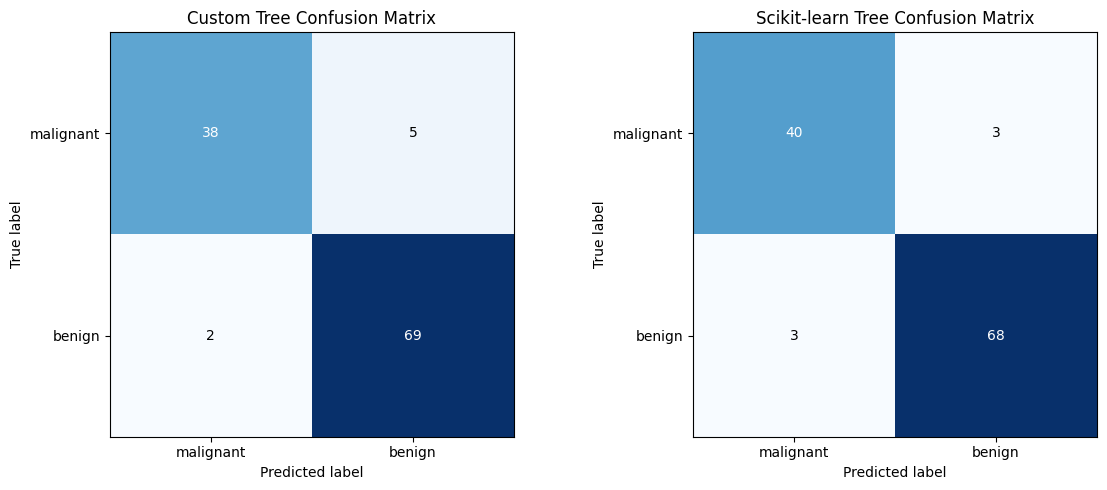

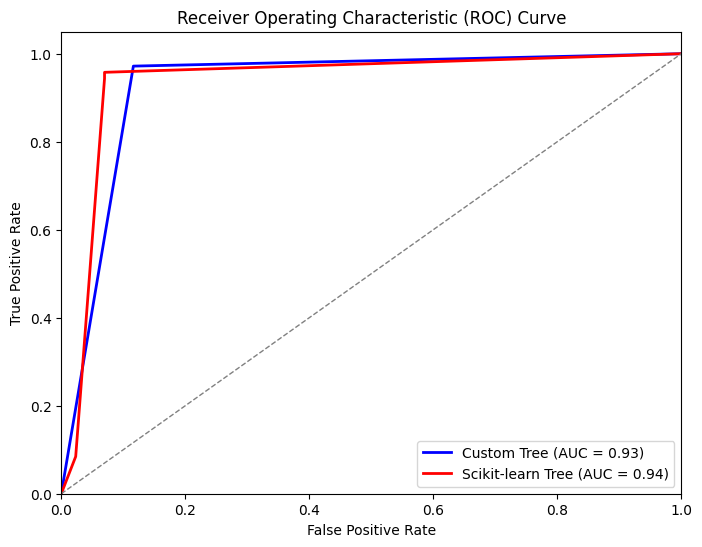



--- Moons Dataset Comparison (Nonlinear Binary Classification) ---
Custom Tree Accuracy: 0.8700
Scikit-learn Tree Accuracy: 0.8850


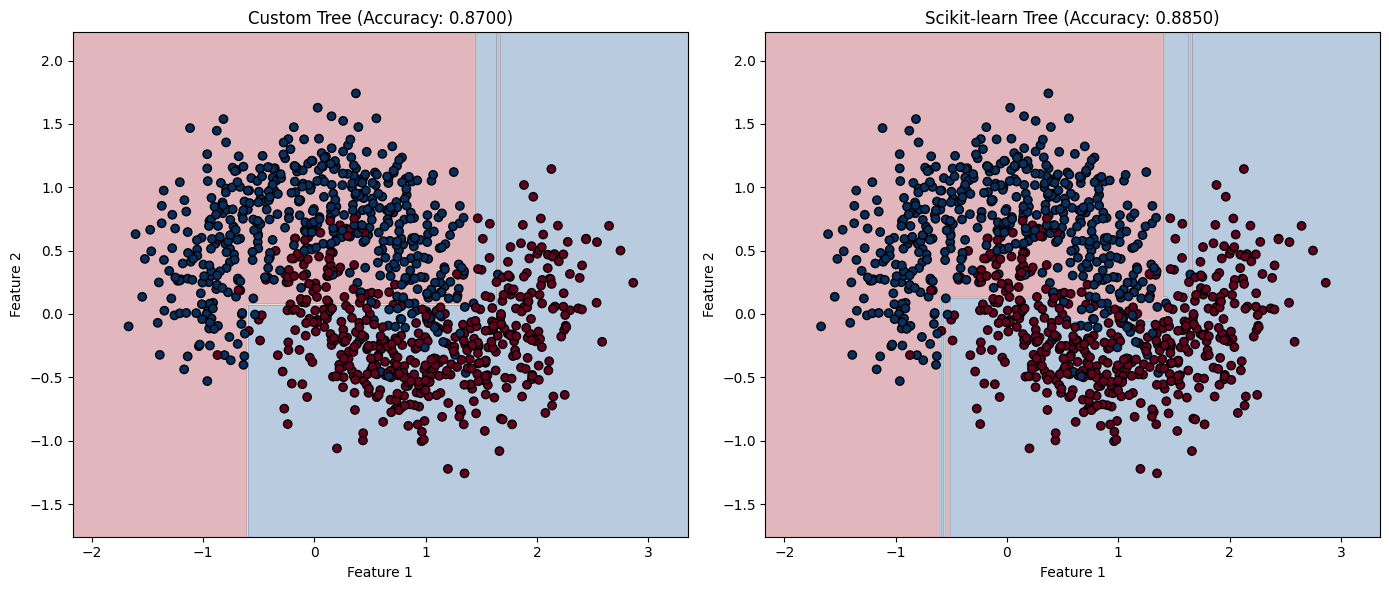

In [46]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import time

# Load binary classification dataset (breast cancer)
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DataFrame for your custom tree
X_train_df = pd.DataFrame(X_train, columns=cancer.feature_names)
X_test_df = pd.DataFrame(X_test, columns=cancer.feature_names)

print("Dataset: Breast Cancer (Binary Classification)")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Classes: {cancer.target_names}")

# 1. Train your custom decision tree
print("\nTraining custom decision tree...")
start_time = time.time()
custom_tree = DecisionTree(max_depth=5)
custom_tree.fit(X_train_df, y_train)
custom_train_time = time.time() - start_time

# Make predictions with your custom tree
start_time = time.time()
custom_pred = custom_tree.predict(X_test_df)
custom_predict_time = time.time() - start_time
custom_accuracy = accuracy_score(y_test, custom_pred)

# 2. Train scikit-learn's decision tree
print("Training scikit-learn decision tree...")
start_time = time.time()
sklearn_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_train_time = time.time() - start_time

# Make predictions with scikit-learn's tree
start_time = time.time()
sklearn_pred = sklearn_tree.predict(X_test)
sklearn_predict_time = time.time() - start_time
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)

# Print comparison results
print("\n--- Performance Comparison ---")
print(f"{'Metric':<20} {'Custom Tree':<15} {'Scikit-learn Tree':<15}")
print("-" * 50)
print(f"{'Accuracy':<20} {custom_accuracy:.4f}{' ':10} {sklearn_accuracy:.4f}")
print(f"{'Training time (s)':<20} {custom_train_time:.4f}{' ':10} {sklearn_train_time:.4f}")
print(f"{'Prediction time (s)':<20} {custom_predict_time:.4f}{' ':10} {sklearn_predict_time:.4f}")

# Compare classification reports
print("\n--- Custom Tree Classification Report ---")
print(classification_report(y_test, custom_pred, target_names=cancer.target_names))

print("\n--- Scikit-learn Tree Classification Report ---")
print(classification_report(y_test, sklearn_pred, target_names=cancer.target_names))

# Compare confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Custom tree confusion matrix
cm1 = confusion_matrix(y_test, custom_pred)
im1 = ax1.imshow(cm1, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title("Custom Tree Confusion Matrix")
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(cancer.target_names)
ax1.set_yticklabels(cancer.target_names)
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

# Add text annotations to the custom tree confusion matrix
for i in range(2):
    for j in range(2):
        ax1.text(j, i, str(cm1[i, j]), ha="center", va="center", color="white" if cm1[i, j] > cm1.max() / 2 else "black")

# Scikit-learn tree confusion matrix
cm2 = confusion_matrix(y_test, sklearn_pred)
im2 = ax2.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title("Scikit-learn Tree Confusion Matrix")
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(cancer.target_names)
ax2.set_yticklabels(cancer.target_names)
ax2.set_xlabel('Predicted label')
ax2.set_ylabel('True label')

# Add text annotations to the scikit-learn tree confusion matrix
for i in range(2):
    for j in range(2):
        ax2.text(j, i, str(cm2[i, j]), ha="center", va="center", color="white" if cm2[i, j] > cm2.max() / 2 else "black")

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# Compare ROC curves
plt.figure(figsize=(8, 6))

# Try to get probabilities if your custom tree supports it
# If not, just use the predictions
try:
    custom_probs = custom_tree.predict_proba(X_test_df)[:, 1]
except:
    # If predict_proba is not implemented, use binary predictions
    custom_probs = custom_pred

# Get scikit-learn probabilities
sklearn_probs = sklearn_tree.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for custom tree
fpr_custom, tpr_custom, _ = roc_curve(y_test, custom_probs)
roc_auc_custom = auc(fpr_custom, tpr_custom)

# Calculate ROC curve and AUC for scikit-learn tree
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, sklearn_probs)
roc_auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

# Plot ROC curves
plt.plot(fpr_custom, tpr_custom, color='blue', lw=2, label=f'Custom Tree (AUC = {roc_auc_custom:.2f})')
plt.plot(fpr_sklearn, tpr_sklearn, color='red', lw=2, label=f'Scikit-learn Tree (AUC = {roc_auc_sklearn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curves.png')
plt.show()

# Try another binary dataset for comparison
from sklearn.datasets import make_moons

# Create a more challenging dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DataFrame for your custom tree
X_train_df = pd.DataFrame(X_train, columns=['Feature 1', 'Feature 2'])
X_test_df = pd.DataFrame(X_test, columns=['Feature 1', 'Feature 2'])

print("\n\n--- Moons Dataset Comparison (Nonlinear Binary Classification) ---")

# Custom tree
custom_tree = DecisionTree(max_depth=5)
custom_tree.fit(X_train_df, y_train)
custom_pred = custom_tree.predict(X_test_df)
custom_accuracy = accuracy_score(y_test, custom_pred)

# Scikit-learn tree
sklearn_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_pred = sklearn_tree.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)

print(f"Custom Tree Accuracy: {custom_accuracy:.4f}")
print(f"Scikit-learn Tree Accuracy: {sklearn_accuracy:.4f}")

# Visualize decision boundaries
def plot_decision_boundary(model, X, y, title, ax):
    # Set min and max values with some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Make predictions on the mesh grid
    if hasattr(model, 'predict'):
        if model.__class__.__name__ == 'DecisionTree':  # Custom model
            mesh_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], 
                                  columns=['Feature 1', 'Feature 2'])
            Z = model.predict(mesh_df)
        else:  # Scikit-learn model
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu_r, edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot decision boundaries
plot_decision_boundary(custom_tree, X, y, f'Custom Tree (Accuracy: {custom_accuracy:.4f})', ax1)
plot_decision_boundary(sklearn_tree, X, y, f'Scikit-learn Tree (Accuracy: {sklearn_accuracy:.4f})', ax2)

plt.tight_layout()
plt.savefig('decision_boundaries.png')
plt.show()